In [69]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd

In [70]:
plotting.setup_mpl
ff1.Cache.enable_cache('../cache')


In [71]:
race = ff1.get_session(2022, 'Russian GP', 'R')
laps = race.load_laps(with_telemetry=True)

c:\Users\MXNOJBE\AppData\Local\Programs\Python\Python310\lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Austrian Grand Prix - Race [v2.3.0]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached 

In [72]:
race
laps
laps['RaceLapNumber'] = laps['LapNumber']-1
laps = laps.loc[laps['RaceLapNumber']>=45]


In [73]:
drivers = pd.unique(laps['Driver'])
telemetry = pd.DataFrame()

for driver in drivers:
    driver_laps = laps.pick_driver(driver)
    for lap in driver_laps.iterlaps():
        driver_telemetry = lap[1].get_telemetry().add_distance()
        driver_telemetry['Driver'] = driver
        driver_telemetry['Lap'] = lap[1]['RaceLapNumber']
        driver_telemetry['Compound'] = lap[1]['Compound']

        telemetry = telemetry.append(driver_telemetry)


C:\Users\MXNOJBE\AppData\Local\Temp\ipykernel_8576\2429161426.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(driver_telemetry)
C:\Users\MXNOJBE\AppData\Local\Temp\ipykernel_8576\2429161426.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(driver_telemetry)
C:\Users\MXNOJBE\AppData\Local\Temp\ipykernel_8576\2429161426.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(driver_telemetry)
C:\Users\MXNOJBE\AppData\Local\Temp\ipykernel_8576\2429161426.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(driver_telemet

In [74]:
telemetry  = telemetry[['Lap', 'Distance', 'Speed','Compound','X','Y']]
telemetry['Compound'].loc[telemetry['Compound'] != 'INTERMEDIATE'] = 'SLICK'


In [75]:
num_minisectors = 25
total_distance = max(telemetry['Distance'])
minisector_length = total_distance/num_minisectors
minisectors = [0]
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i+1))
telemetry['Minisector'] = telemetry['Distance'].apply(lambda z: minisectors.index(min(minisectors, key=lambda x:abs(x-z))))+1


In [76]:
average_speed = telemetry.groupby(['Lap', 'Minisector','Compound'])['Speed'].mean().reset_index()
average_speed

,Lap,Minisector,Compound,Speed
0,45,1,SLICK,281.240223
1,45,2,SLICK,291.655738
2,45,3,SLICK,218.104019
3,45,4,SLICK,164.905556
4,45,5,SLICK,250.139276
...,...,...,...,...
645,70,21,SLICK,286.415584
646,70,22,SLICK,280.623529
647,70,23,SLICK,229.076923
648,70,24,SLICK,190.091667


In [77]:
fastest_compounds = average_speed.loc[average_speed.groupby(['Lap', 'Minisector'])['Speed'].idxmax()]

In [78]:
fastest_compounds = fastest_compounds[['Lap', 'Minisector', 'Compound']].rename(columns={'Compound': 'Fastest_compound'})

In [79]:
telemetry = telemetry.merge(fastest_compounds, on=['Lap', 'Minisector'])
telemetry = telemetry.sort_values(by=['Distance'])
telemetry.loc[telemetry['Fastest_compound'] == "INTERMEDIATE", 'Fastest_compound_int'] = 1
telemetry.loc[telemetry['Fastest_compound'] == "SLICK", 'Fastest_compound_int'] = 2

In [80]:
def generate_minisector_plot(lap, save=False, details=True):
    single_lap = telemetry.loc[telemetry['Lap'] == lap]

    x = np.array(single_lap['X'].values)
    y = np.array(single_lap['Y'].values)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    compound = single_lap['Fastest_compound_int'].to_numpy().astype(float)

    cmap = cm.get_cmap('ocean', 2)
    lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    lc_comp.set_array(compound)
    lc_comp.set_linewidth(2)

    plt.rcParams['figure.figsize'] = [12, 5]
    
    if details:
        title = plt.suptitle(
            f"2021 Russian GP \n Lap {lap} - Slicks vs. Inters"
        )
        
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    
    if details:
        cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1, 4))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(['Inters', 'Slicks'])
    
    

    plt.show()

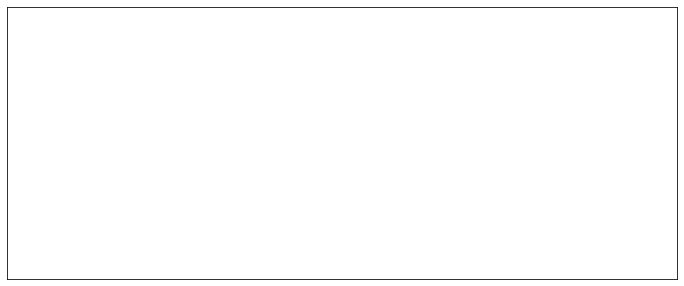

In [81]:
generate_minisector_plot(46, save=True, details=False)